## This Code is to convert the image jpg and steering_angle.csv to TFRecord files in multithread, and batch handling in training.

In [3]:
import pandas as pd
import numpy as np

#read dataframe of steering wheel angle
df_steering = pd.read_csv('steering.csv')
df_steering = df_steering[['timestamp','angle']] # keep only timestamp and angle

#read dataframe of camera information
df_camera = pd.read_csv('camera.csv')

# obtain only the center_camera
df_center_camera = df_camera[df_camera['frame_id'] == 'center_camera']

#reorder the index of the df_center_camera
df_center_camera = df_camera[df_camera['frame_id'] == 'center_camera']
df_center_camera.index = range(df_center_camera.shape[0])
df_center_camera = df_center_camera[['timestamp','filename']] # keep only timestamp and image filename

#build a new dataframe which will be the best matching between steering angle and camera filename based on closest epoch timestamp
# merge two dataframe based on sorted timestamp
df_paired = pd.merge(df_center_camera, df_steering, on='timestamp', how='outer',sort='timestamp')

#use the immediate next row's angle to join the current row's angle, where the current row is the row that has camera filename at current timestamp
df_paired['angle'][np.where(df_paired['filename'].notnull())[0]] = df_paired['angle'][np.where(df_paired['filename'].notnull())[0] + 1]  
input_df = df_paired.dropna()
input_df.index = range(input_df.shape[0])
# input_df



/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
import os
import random
import sys
import threading


import numpy as np
import tensorflow as tf

tf.app.flags.DEFINE_string('train_directory', '',
                           'Training data directory')
tf.app.flags.DEFINE_string('validation_directory', '',
                           'Validation data directory')
tf.app.flags.DEFINE_string('output_directory', '',
                           'Output data directory')

tf.app.flags.DEFINE_integer('train_shards', 2,
                            'Number of shards in training TFRecord files.')
tf.app.flags.DEFINE_integer('validation_shards', 10,
                            'Number of shards in validation TFRecord files.')

tf.app.flags.DEFINE_integer('num_threads', 4,
                            'Number of threads to preprocess the images.')
tf.app.flags.DEFINE_string('labels_file', '', 'Labels file')


FLAGS = tf.app.flags.FLAGS




In [77]:
def _int64_feature(value):
  """Wrapper for inserting int64 features into Example proto."""
  if not isinstance(value, list):
    value = [value]
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _float32_feature(value):
  """Wrapper for inserting float32 features into Example proto."""
  if not isinstance(value, list):
    value = [value]
#   return tf.train.Feature()
  return tf.train.Feature(float32_list=tf.train.Float32List(value=value))

def _bytes_feature(value):
  """Wrapper for inserting bytes features into Example proto."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _convert_to_example(filename, image_buffer, label, text, height, width):

  colorspace = 'RGB'
  channels = 3
  image_format = 'JPEG'

  example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': _int64_feature(height),
      'image/width': _int64_feature(width),
      'image/colorspace': _bytes_feature(colorspace),
      'image/channels': _int64_feature(channels),
      'image/class/label': _int64_feature(int(label*100000)), #cast into integer 
      'image/class/text': _int64_feature(int(text*100000)),
      'image/format': _bytes_feature(image_format),
      'image/filename': _bytes_feature(os.path.basename(filename)),
      'image/encoded': _bytes_feature(image_buffer)}))
  return example


class ImageCoder(object):
  """Helper class that provides TensorFlow image coding utilities."""

  def __init__(self):
    # Create a single Session to run all image coding calls.
    self._sess = tf.Session()

    # Initializes function that converts PNG to JPEG data.
    self._png_data = tf.placeholder(dtype=tf.string)
    image = tf.image.decode_png(self._png_data, channels=3)
    self._png_to_jpeg = tf.image.encode_jpeg(image, format='rgb', quality=100)

    # Initializes function that decodes RGB JPEG data.
    self._decode_jpeg_data = tf.placeholder(dtype=tf.string)
    self._decode_jpeg = tf.image.decode_jpeg(self._decode_jpeg_data, channels=3)

  def png_to_jpeg(self, image_data):
    return self._sess.run(self._png_to_jpeg,
                          feed_dict={self._png_data: image_data})

  def decode_jpeg(self, image_data):
    image = self._sess.run(self._decode_jpeg,
                           feed_dict={self._decode_jpeg_data: image_data})
    assert len(image.shape) == 3
    assert image.shape[2] == 3
    return image


def _process_image(filename, coder):
  # Read the image file.
  with tf.gfile.FastGFile(filename, 'r') as f:
    image_data = f.read()

  # Convert any PNG to JPEG's for consistency.
#   if _is_png(filename):
#     print('Converting PNG to JPEG for %s' % filename)
#     image_data = coder.png_to_jpeg(image_data)

  # Decode the RGB JPEG.
  image = coder.decode_jpeg(image_data)

  # Check that image converted to RGB
  assert len(image.shape) == 3
  height = image.shape[0]
  width = image.shape[1]
  assert image.shape[2] == 3

  return image_data, height, width


def _process_image_files_batch(coder, thread_index, ranges, name, filenames,
                               texts, labels, num_shards):
  num_threads = len(ranges)
  assert not num_shards % num_threads
  num_shards_per_batch = int(num_shards / num_threads)

  shard_ranges = np.linspace(ranges[thread_index][0],
                             ranges[thread_index][1],
                             num_shards_per_batch + 1).astype(int)
  num_files_in_thread = ranges[thread_index][1] - ranges[thread_index][0]

  counter = 0
  for s in xrange(num_shards_per_batch):
    # Generate a sharded version of the file name, e.g. 'train-00002-of-00010'
    shard = thread_index * num_shards_per_batch + s
    output_filename = '%s-%.5d-of-%.5d' % (name, shard, num_shards)
    output_file = os.path.join(FLAGS.output_directory, output_filename)
    writer = tf.python_io.TFRecordWriter(output_file)

    shard_counter = 0
    files_in_shard = np.arange(shard_ranges[s], shard_ranges[s + 1], dtype=int)
    for i in files_in_shard:
      filename = filenames[i]
      label = labels[i]
      text = texts[i]

      image_buffer, height, width = _process_image(filename, coder)

      example = _convert_to_example(filename, image_buffer, label,
                                    text, height, width)
      writer.write(example.SerializeToString())
      shard_counter += 1
      counter += 1

      if not counter % 1000:
        print('%s [thread %d]: Processed %d of %d images in thread batch.' %
              (datetime.now(), thread_index, counter, num_files_in_thread))
        sys.stdout.flush()

    writer.close()
    print('%s [thread %d]: Wrote %d images to %s' %
          (datetime.now(), thread_index, shard_counter, output_file))
    sys.stdout.flush()
    shard_counter = 0
  print('%s [thread %d]: Wrote %d images to %d shards.' %
        (datetime.now(), thread_index, counter, num_files_in_thread))
  sys.stdout.flush()


def _process_image_files(name, filenames, texts, labels, num_shards):
  assert len(filenames) == len(texts)
  assert len(filenames) == len(labels)

  # Break all images into batches with a [ranges[i][0], ranges[i][1]].
  spacing = np.linspace(0, len(filenames), FLAGS.num_threads + 1).astype(np.int)
  ranges = []
  for i in xrange(len(spacing) - 1):
    ranges.append([spacing[i], spacing[i+1]])

  # Launch a thread for each batch.
  print('Launching %d threads for spacings: %s' % (FLAGS.num_threads, ranges))
  sys.stdout.flush()

  # Create a mechanism for monitoring when all threads are finished.
  coord = tf.train.Coordinator()

  # Create a generic TensorFlow-based utility for converting all image codings.
  coder = ImageCoder()
  
  threads = []
  for thread_index in xrange(len(ranges)):
    args = (coder, thread_index, ranges, name, filenames,
            texts, labels, num_shards)
    t = threading.Thread(target=_process_image_files_batch, args=args)
    t.start()
    threads.append(t)

    
  # Wait for all the threads to terminate.
  coord.join(threads)
  print('%s: Finished writing all %d images in data set.' %
        (datetime.now(), len(filenames)))
  sys.stdout.flush()


def _process_dataset(name, directory, num_shards, labels_file):
  _process_image_files(name, filenames, texts, labels, num_shards)


def main(unused_argv):
  pass

if __name__ == '__main__':
  print ("do nothing")
#   tf.app.run()

do nothing


In [78]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())
# fileNameList = input_df[:10000]['filename'].tolist()
fileNameList = input_df[50000:55000]['filename'].tolist() # convert input data from index = 50000 to 55000 into TFRecords
# labels = input_df['angle'][:10000].tolist()
labels = input_df['angle'][50000:55000].tolist()
name = "training"
texts = labels
_process_image_files(name, fileNameList, texts, labels, num_shards=2)

Launching 1 threads for spacings: [[0, 5000]]
2016-11-28 23:30:05.215953 [thread 0]: Processed 1000 of 5000 images in thread batch.
2016-11-28 23:30:09.209106 [thread 0]: Processed 2000 of 5000 images in thread batch.
2016-11-28 23:30:12.103359 [thread 0]: Wrote 2500 images to training-00000-of-00002
2016-11-28 23:30:14.202901 [thread 0]: Processed 3000 of 5000 images in thread batch.
2016-11-28 23:30:18.239968 [thread 0]: Processed 4000 of 5000 images in thread batch.
2016-11-28 23:30:22.317421 [thread 0]: Processed 5000 of 5000 images in thread batch.
2016-11-28 23:30:23.053442 [thread 0]: Wrote 2500 images to training-00001-of-00002
2016-11-28 23:30:23.055180 [thread 0]: Wrote 5000 images to 5000 shards.
2016-11-28 23:30:23.170761: Finished writing all 5000 images in data set.


### Loadan

In [88]:
def read_and_decode_single_example(filename):
  # Construct the filename queue
  filename_queue = tf.train.string_input_producer(filename, num_epochs=None)
  # declare the reader
  reader = tf.TFRecordReader()
  # Reader read the file from file_queue
  _,serialized_example = reader.read(filename_queue)
  # decode the TFRecords file based on defined features in protocol buffer
  features = tf.parse_single_example(
    serialized_example,
    features = {
      'image/encoded': tf.FixedLenFeature([], tf.string), # image decoding
      'image/class/label': tf.FixedLenFeature([], dtype=tf.int64,# label decoding as integer, then be convert to float later
                                              default_value=1)
        })
  image = tf.image.decode_jpeg(features['image/encoded'], channels=3)
#   image = tf.cast(image, tf.float32) * (1. / 255) - 0.5
  label = tf.cast(features['image/class/label'], tf.float32)
  label = label /100000
  return label,image

labels,images = read_and_decode_single_example(['training-00000-of-00002','training-00001-of-00002'])

sess = tf.Session()

init = tf.initialize_all_variables()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

# grab examples back.
# first example from file
allLabels = np.zeros([1000], dtype=np.float32)
allImages = np.zeros([1000,480,640,3],dtype=np.uint8)

for i in range(1000):
  lab,img = sess.run([labels, images])
  allLabels[i] = lab
  allImages[i,:,:,:] = img

-0.02792


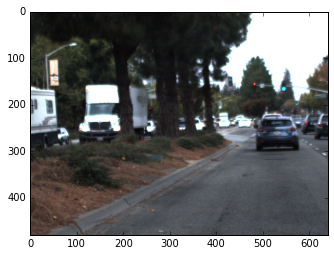

In [95]:
# take one frame as example
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(allImages[250,:,:,:])
print (allLabels[250])

